---

<div>
    
[Timeseries](#Timeseries)
* [Različni tipi Deep Learning modelov](#Različni-tipi-Deep-Learning-modelov)
    
[Realni primer](#Realni-primer)
* [Data exploration](#Data-exploration)
* [Feature engineering and data splitting](#Feature-engineering-and-data-splitting)
    * [Encoding time](#Encoding-time)

[Data windowing](#Data-windowing)
* [Shape of timeseries data for deep learning](#Shape-of-timeseries-data-for-deep-learning)
* [Implementing the DataWindow class](#Implementing-the-DataWindow-class)

[Baseline models](#Baseline-models)
* [Single step baseline model](#Single-step-baseline-model)
* [Multi step baseline models](#Multi-step-baseline-models)
    * [Predicting using last known value](#Predicting-using-last-known-value)
    * [Predicting using whole input sequence](#Predicting-using-whole-input-sequence)
* [Multi output baseline model](#Multi-output-baseline-model)
    
[Deep Learning](#Deep-Learning)
* [Single Step DNN model](#Single-Step-DNN-model)
* [Multi-Step DNN model](#Multi-Step-DNN-model)
* [Multi-Output DNN model](#Multi-Output-DNN-model)
    
[Remembering the past](#Remembering-the-past)
* [Recurrent Neural Network (RNN)](#Recurrent-Neural-Network-(RNN))
* [Long Short-Term Memory](#Long-Short-Term-Memory)
    * [Forget gate](#Forget-gate)
    * [Input gate](#Input-gate)
    * [Output gate](#Output-gate)
* [Single-Step LSTM](#Single-Step-LSTM)
* [Multi-Step LSTM](#Multi-Step-LSTM)
* [Multi-Output LSTM](#Multi-Output-LSTM)
</div>

# Timeseries

## Različni tipi Deep Learning modelov

**Single-step model**

![single_step](images/01_single_step_model.png)

**Multi-step model**

![02_multi_step_model](images/02_multi_step.png)

**Multi-output model**

![multi_output](images/03_multi_output.png)

---

# Realni primer

## Data exploration

In [2]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("./data/metro_interstate_traffic_volume_preprocessed.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17551 entries, 0 to 17550
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       17551 non-null  object 
 1   temp            17551 non-null  float64
 2   rain_1h         17551 non-null  float64
 3   snow_1h         17551 non-null  int64  
 4   clouds_all      17551 non-null  int64  
 5   traffic_volume  17551 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 822.8+ KB
None


,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


| Feature        | Description |
|----------------|-------------|
| date_time      | Date and time of the data, recorded in the CST time zone. The format is YYYY-MM-DD HH:MM:SS. |
| temp           | Average temperature recorded in the hour, expressed in Kelvin.                               |
| rain_1h        | Amount of rain that occurred in the hour, expressed in millimeters.                          |
| snow_1h        | Amount of snow that occurred in the hour, expressed in millimeters.                          |
| clouds_all     | Percentage of cloud cover during the hour.                                                   |
| traffic_volume | Volume of traffic reported westbound on I-94 during the hour.                                |


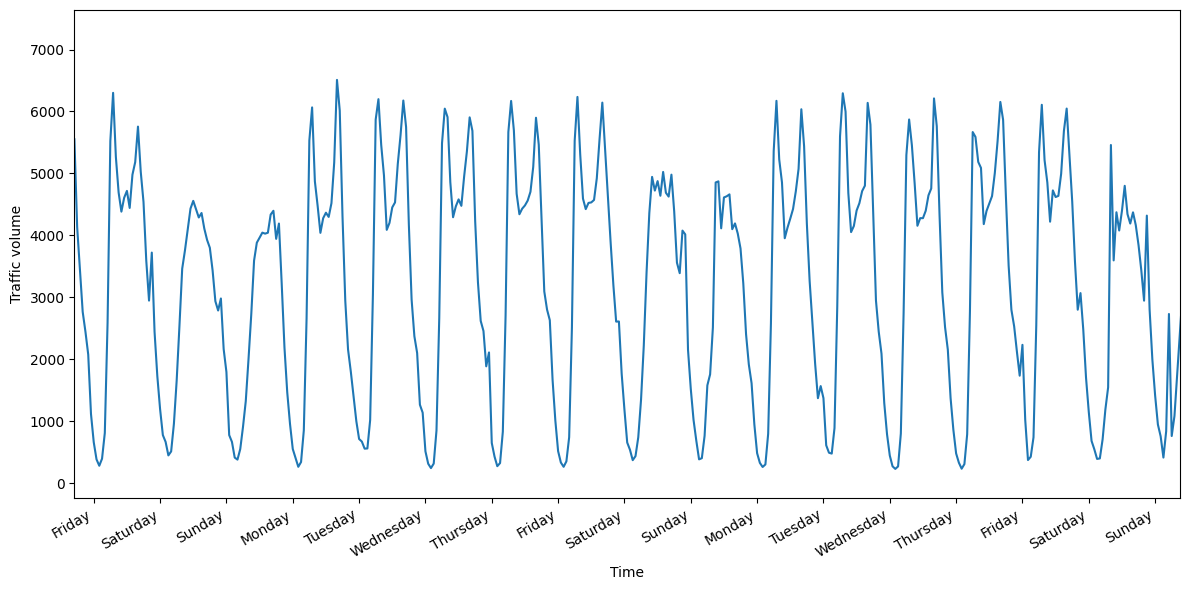

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["traffic_volume"])
ax.set_xlabel("Time")
ax.set_ylabel("Traffic volume")

plt.xticks(np.arange(7, 400, 24),  ['Friday', 'Saturday', 'Sunday',
                                   'Monday', 'Tuesday', 'Wednesday', 
                                   'Thursday', 'Friday', 'Saturday',
                                   'Sunday', 'Monday', 'Tuesday', 
                                   'Wednesday', 'Thursday', 'Friday',
                                   'Saturday', 'Sunday'])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

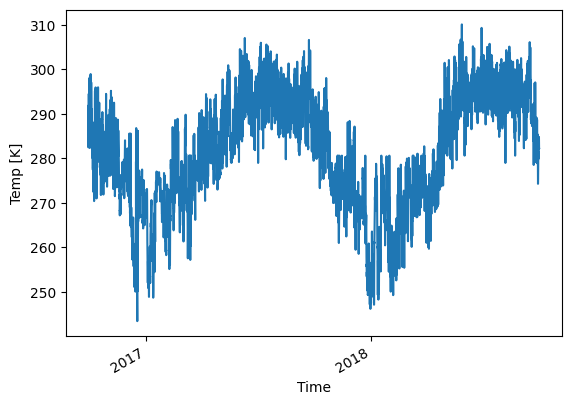

In [9]:
fig, ax = plt.subplots()
ax.plot(df["temp"])
ax.set_xlabel("Time")
ax.set_ylabel("Temp [K]")
plt.xticks([2239, 10999], [2017, 2018])
fig.autofmt_xdate()
plt.show()

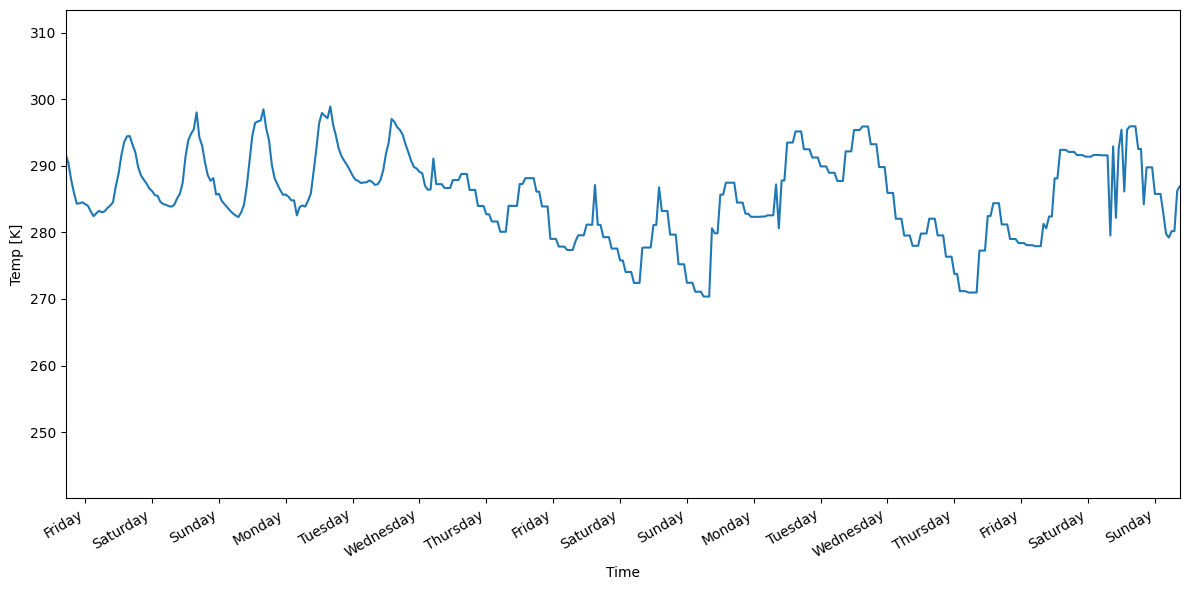

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["temp"])
ax.set_xlabel("Time")
ax.set_ylabel("Temp [K]")

plt.xticks(np.arange(7, 400, 24),  ['Friday', 'Saturday', 'Sunday',
                                   'Monday', 'Tuesday', 'Wednesday', 
                                   'Thursday', 'Friday', 'Saturday',
                                   'Sunday', 'Monday', 'Tuesday', 
                                   'Wednesday', 'Thursday', 'Friday',
                                   'Saturday', 'Sunday'])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

## Feature engineering and data splitting

In [11]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,17551.000000,17551.000000,17551.0,17551.000000,17551.000000
mean,281.416203,0.025523,0.0,42.034129,3321.484588
std,12.688262,0.259794,0.0,39.065960,1969.223949
min,243.390000,0.000000,0.0,0.000000,113.000000
25%,272.220000,0.000000,0.0,1.000000,1298.000000
50%,282.410000,0.000000,0.0,40.000000,3518.000000
75%,291.890000,0.000000,0.0,90.000000,4943.000000
max,310.070000,10.600000,0.0,100.000000,7280.000000


In [12]:
cols_to_drop = ["rain_1h", "snow_1h"]
df = df.drop(cols_to_drop, axis=1)
df.head()

,date_time,temp,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0,5551.0
1,2016-09-29 18:00:00,290.36,0,4132.0
2,2016-09-29 19:00:00,287.86,0,3435.0
3,2016-09-29 20:00:00,285.91,0,2765.0
4,2016-09-29 21:00:00,284.31,0,2443.0


### Encoding time

In [13]:
timestamp_s = pd.to_datetime(df["date_time"]).map(datetime.datetime.timestamp)
timestamp_s

0        1.475161e+09
1        1.475165e+09
2        1.475168e+09
3        1.475172e+09
4        1.475176e+09
             ...     
17546    1.538327e+09
17547    1.538330e+09
17548    1.538334e+09
17549    1.538338e+09
17550    1.538341e+09
Name: date_time, Length: 17551, dtype: float64

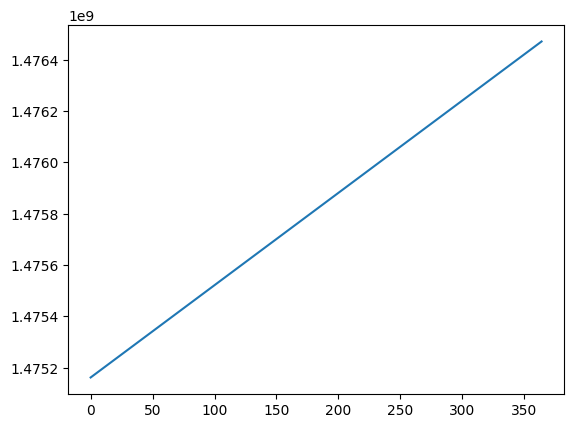

In [14]:
timestamp_s[:365].plot()
plt.show()

In [15]:
day = 24*60*60
df["day_sin"] = np.sin(timestamp_s * (2*np.pi/day)).values
df.head()

,date_time,temp,clouds_all,traffic_volume,day_sin
0,2016-09-29 17:00:00,291.75,0,5551.0,-0.707107
1,2016-09-29 18:00:00,290.36,0,4132.0,-0.866025
2,2016-09-29 19:00:00,287.86,0,3435.0,-0.965926
3,2016-09-29 20:00:00,285.91,0,2765.0,-1.000000
4,2016-09-29 21:00:00,284.31,0,2443.0,-0.965926


In [16]:
df["day_cos"] = np.cos(timestamp_s * (2*np.pi/day)).values
df.head()

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,291.75,0,5551.0,-0.707107,-7.071068e-01
1,2016-09-29 18:00:00,290.36,0,4132.0,-0.866025,-5.000000e-01
2,2016-09-29 19:00:00,287.86,0,3435.0,-0.965926,-2.588190e-01
3,2016-09-29 20:00:00,285.91,0,2765.0,-1.000000,-4.048636e-12
4,2016-09-29 21:00:00,284.31,0,2443.0,-0.965926,2.588190e-01


In [17]:
df = df.drop(["date_time"], axis=1)

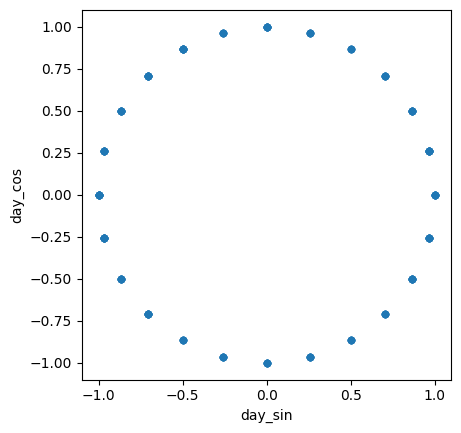

In [18]:
df.sample(200).plot.scatter(x="day_sin", y="day_cos").set_aspect("equal")
plt.show()

In [20]:
n = len(df)

train_df = df[:int(n*0.7)]
val_df = df[int(0.7*n):int(0.9*n)]
test_df = df[int(0.9*n):]

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [23]:
train_df.to_csv("./data/train.csv")
val_df.to_csv("./data/val.csv")
test_df.to_csv("./data/test.csv")

----

# Data windowing

## Shape of timeseries data for deep learning

![fig_13_1](images/04_figure13_1.png)

![fig_13_2](images/05_13_2.png)

---

![13_03](images/06_fig_13_3.png)

![13_4](images/07_13_04.png)

![fig_13_05](images/08_fig_13_5.png)

## Implementing the DataWindow class

In [24]:
import tensorflow as tf

In [27]:
class DataWindow:
    def __init__(self, input_windth, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        self.train_df = train-df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = oinput_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slivce = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

![window_splitg](images/09_window_split.png)

In [33]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            # Used for plotting
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    # vvvvv     HERE     vvvvv
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result
    # ^^^^^     HERE     ^^^^^
    
    

---

# Baseline models

## Single-step baseline model

In [36]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=["traffic_volume"])

In [37]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=["traffic_volume"])

---

In [38]:
from tensorflow.keras import Model

In [41]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        elif isinstance(self.label_index, list):
            tensor = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensor.append(result)
                return tf.concat(tensor, axis=-1)
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

---

In [42]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [45]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices["traffic_volume"])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [47]:
val_performance = {}
performance = {}

val_performance["Baseline - Last"] = baseline_last.evaluate(single_step_window.val)
performance["Baseline - Last"]= baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 0s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


In [50]:
print(performance["Baseline - Last"][1])

0.08128400146961212


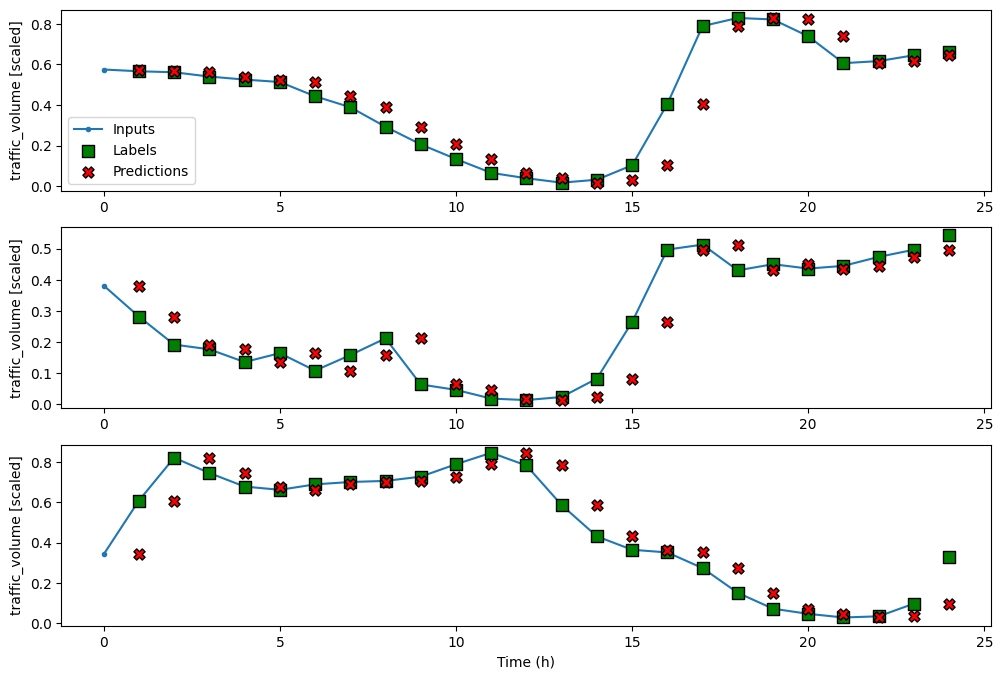

In [51]:
wide_window.plot(baseline_last)
plt.show()

## Multi-step baseline models

### Predicting using last known value

In [52]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=["traffic_volume"])

### Predicting using whole input sequence

In [56]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [57]:
ms_baseline_last = MultiStepLastBaseline(label_index = column_indices["traffic_volume"])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [58]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance["Baseline - Lase"] = ms_baseline_last.evaluate(multi_window.val)
ms_performance["Baseline - Last"] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.1873 - mean_absolute_error: 0.3520


[]

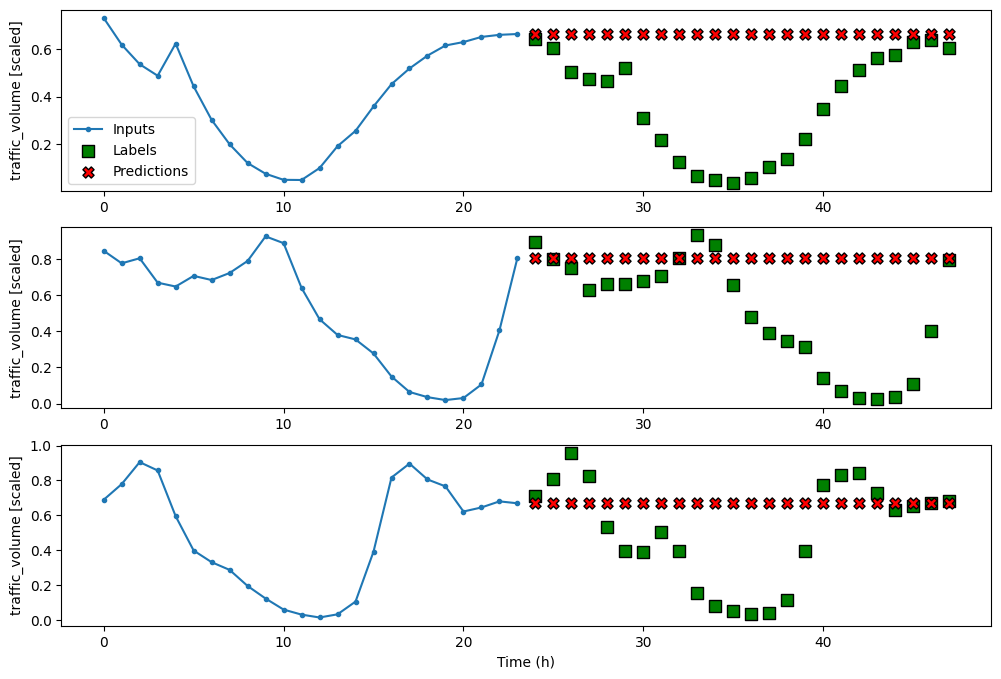

In [59]:
multi_window.plot(ms_baseline_last)
plt.plot()

In [62]:
ms_performance["Baseline - Last"][1]

0.34697431325912476

---

In [65]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [66]:
ms_baseline_repeat = RepeatBaseline(label_index = column_indices["traffic_volume"])
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [67]:
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 3ms/step - loss: 0.1896 - mean_absolute_error: 0.3276


[]

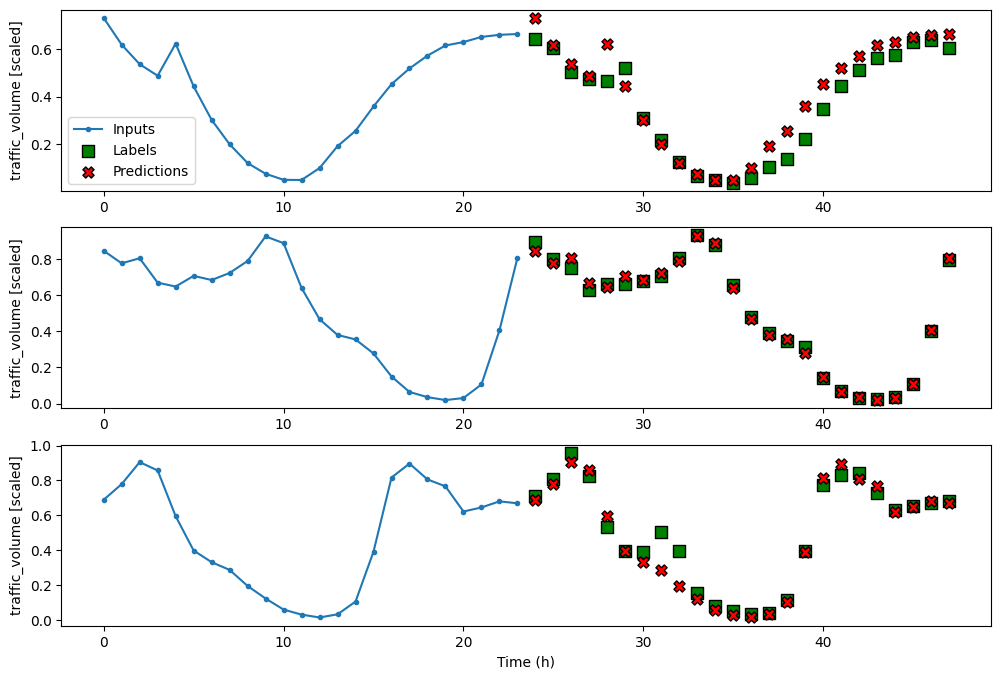

In [68]:
multi_window.plot(ms_baseline_repeat)

plt.plot()

In [69]:
ms_performance["Baseline - Repeat"][1]

0.3153635859489441

## Multi-output baseline model

In [70]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [73]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 1s 3ms/step - loss: 0.0729 - mean_absolute_error: 0.1645


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

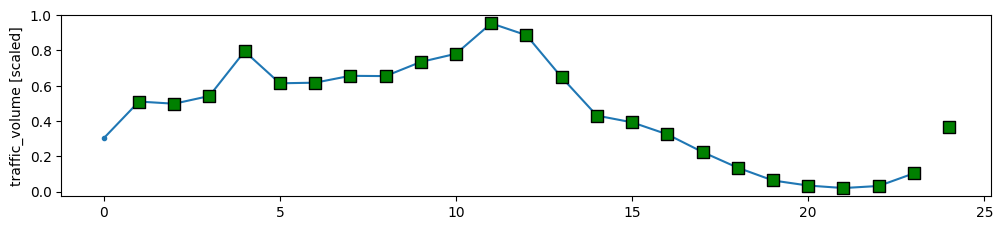

In [74]:
mo_wide_window.plot(mo_baseline_last)

plt.plot()

[]

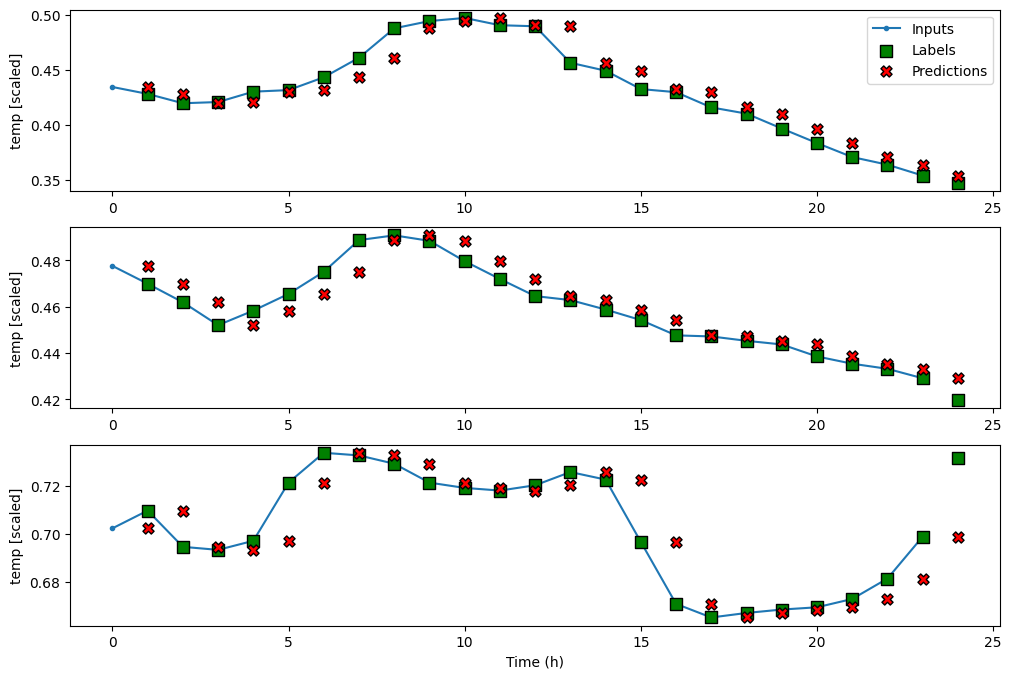

In [75]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

plt.plot()

----

# Deep Learning

In [76]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Lambda, Reshape, RNN, LSTMCell
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [82]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

## Single-Step DNN model

In [83]:
dense = Sequential([
    Dense(units=64, activation="relu"),
    Dense(units=64, activation="relu"),
    Dense(units=1)
])

In [84]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.0111 - mean_absolute_error: 0.0721 - val_loss: 0.0054 - val_mean_absolute_error: 0.0544
Epoch 2/50
384/384 [==============================] - 3s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0508 - val_loss: 0.0041 - val_mean_absolute_error: 0.0488
Epoch 3/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0454 - val_loss: 0.0032 - val_mean_absolute_error: 0.0423
Epoch 4/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0433 - val_loss: 0.0031 - val_mean_absolute_error: 0.0427
Epoch 5/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0413 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411
Epoch 6/50
384/384 [==============================] - 3s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0402 - val_loss: 0.0024 - val_mean_absolute_error: 0.0361
Epoch 7/50
384/3

In [85]:
val_performance["Dense"] = dense.evaluate(single_step_window.val)
performance["Dense"] = dense.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0379


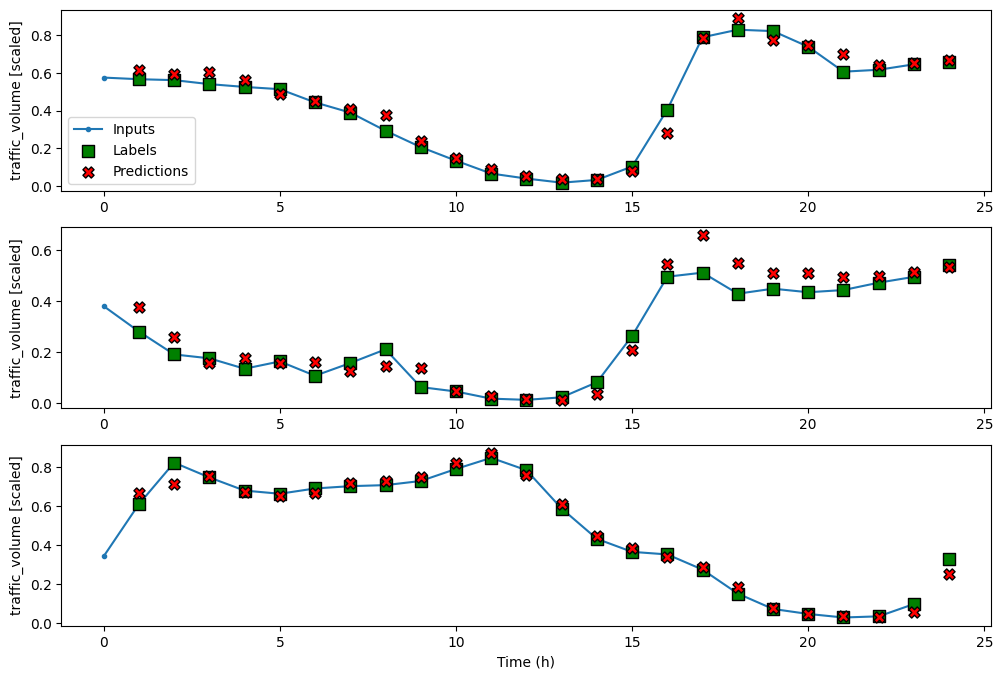

In [86]:
wide_window.plot(dense)

plt.show()

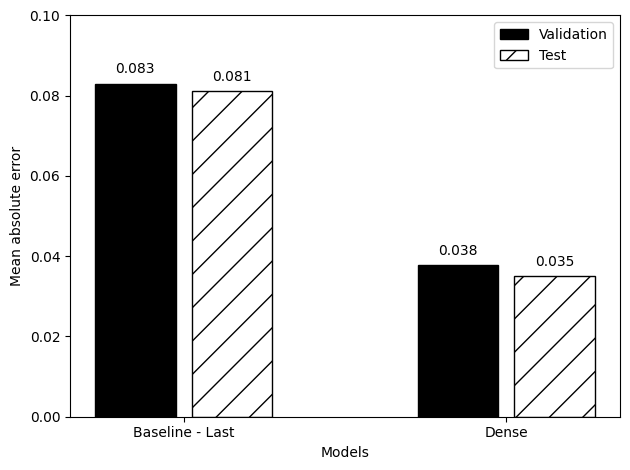

In [87]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.show()

## Multi-Step DNN model

In [88]:
ms_dense = Sequential([
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1)
])

In [89]:
history = compile_and_fit(ms_dense, multi_window)

Epoch 1/50
383/383 [==============================] - 5s 9ms/step - loss: 0.0244 - mean_absolute_error: 0.0985 - val_loss: 0.0163 - val_mean_absolute_error: 0.0833
Epoch 2/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0138 - mean_absolute_error: 0.0781 - val_loss: 0.0156 - val_mean_absolute_error: 0.0833
Epoch 3/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0134 - mean_absolute_error: 0.0773 - val_loss: 0.0154 - val_mean_absolute_error: 0.0845
Epoch 4/50
383/383 [==============================] - 4s 10ms/step - loss: 0.0132 - mean_absolute_error: 0.0774 - val_loss: 0.0161 - val_mean_absolute_error: 0.0843
Epoch 5/50
383/383 [==============================] - 4s 10ms/step - loss: 0.0130 - mean_absolute_error: 0.0765 - val_loss: 0.0152 - val_mean_absolute_error: 0.0840
Epoch 6/50
383/383 [==============================] - 3s 9ms/step - loss: 0.0129 - mean_absolute_error: 0.0767 - val_loss: 0.0147 - val_mean_absolute_error: 0.0797
Epoch 7/50
383

In [90]:
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 6ms/step - loss: 0.0146 - mean_absolute_error: 0.0755


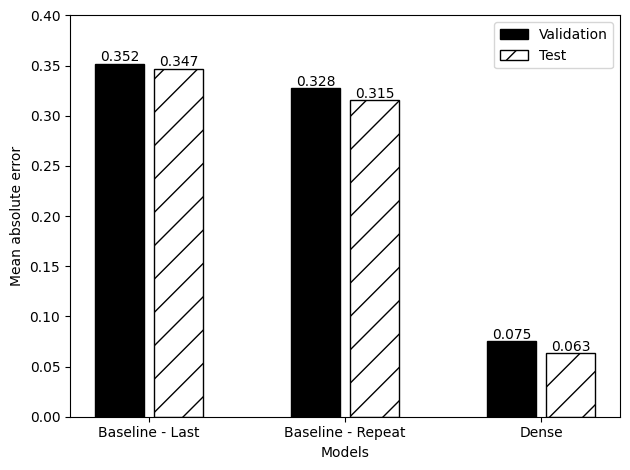

In [91]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.show()

## Multi-Output DNN model

In [92]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

In [93]:
history = compile_and_fit(mo_dense, mo_single_step_window)


Epoch 1/50
384/384 [==============================] - 3s 6ms/step - loss: 0.0137 - mean_absolute_error: 0.0656 - val_loss: 0.0030 - val_mean_absolute_error: 0.0353
Epoch 2/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0329 - val_loss: 0.0024 - val_mean_absolute_error: 0.0321
Epoch 3/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0304 - val_loss: 0.0019 - val_mean_absolute_error: 0.0282
Epoch 4/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0292 - val_loss: 0.0018 - val_mean_absolute_error: 0.0287
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0283 - val_loss: 0.0017 - val_mean_absolute_error: 0.0264
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0020 - mean_absolute_error: 0.0276 - val_loss: 0.0016 - val_mean_absolute_error: 0.0262
Epoch 7/50
384/3

In [94]:
mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

110/110 [==============================] - 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0267


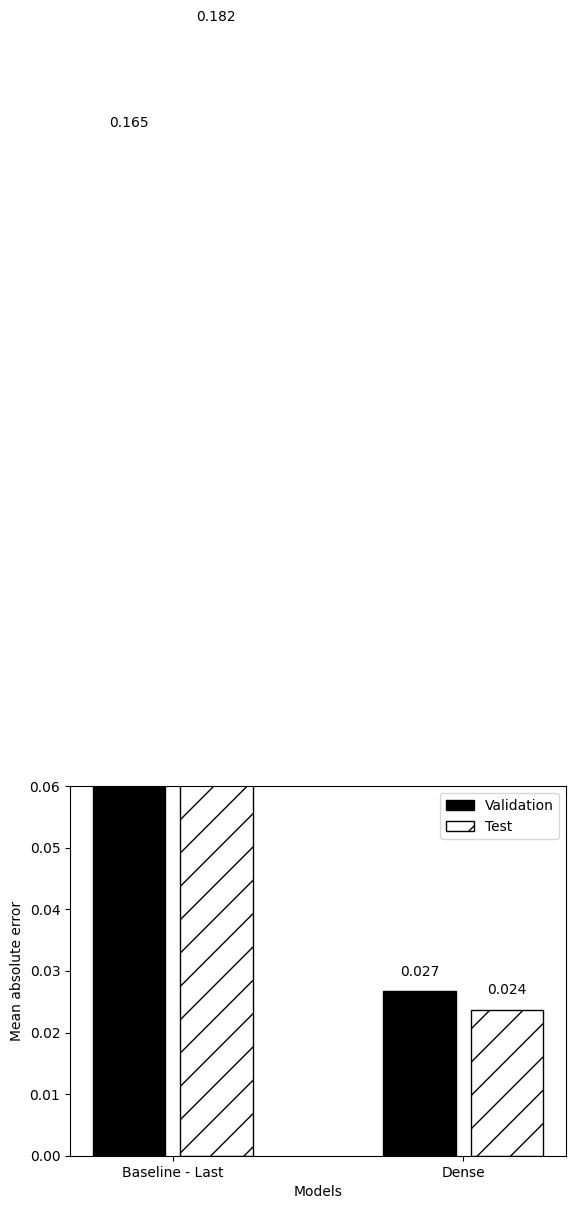

In [96]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.show()

----

# Remembering the past

## Recurrent Neural Network (RNN)

![rnn](images/rnn_model.PNG)

![rnn_expanded](images/rnn_expanded.PNG)

## Long Short-Term Memory

![lstm architecture](images/lstm_architecture.PNG)

### Forget gate

![forget gate](./images/forget_gate.PNG)

### Input gate

![input gate](images/input_gate.PNG)

### Output gate

![output gate](images/output_gate.PNG)

---

## Single-Step LSTM

In [104]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=["traffic_volume"])

In [102]:
lstm_model = Sequential([LSTM(32, return_sequences=True),
                         Dense(units=1)
                        ])

In [103]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
384/384 [==============================] - 15s 28ms/step - loss: 0.0373 - mean_absolute_error: 0.1378 - val_loss: 0.0141 - val_mean_absolute_error: 0.0867
Epoch 2/50
384/384 [==============================] - 11s 28ms/step - loss: 0.0090 - mean_absolute_error: 0.0676 - val_loss: 0.0060 - val_mean_absolute_error: 0.0559
Epoch 3/50
384/384 [==============================] - 11s 29ms/step - loss: 0.0053 - mean_absolute_error: 0.0521 - val_loss: 0.0044 - val_mean_absolute_error: 0.0484
Epoch 4/50
384/384 [==============================] - 9s 24ms/step - loss: 0.0044 - mean_absolute_error: 0.0473 - val_loss: 0.0038 - val_mean_absolute_error: 0.0443
Epoch 5/50
384/384 [==============================] - 11s 29ms/step - loss: 0.0041 - mean_absolute_error: 0.0448 - val_loss: 0.0039 - val_mean_absolute_error: 0.0452
Epoch 6/50
384/384 [==============================] - 10s 25ms/step - loss: 0.0039 - mean_absolute_error: 0.0434 - val_loss: 0.0037 - val_mean_absolute_error: 0.0428
Epoch

In [105]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

109/109 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0293


[]

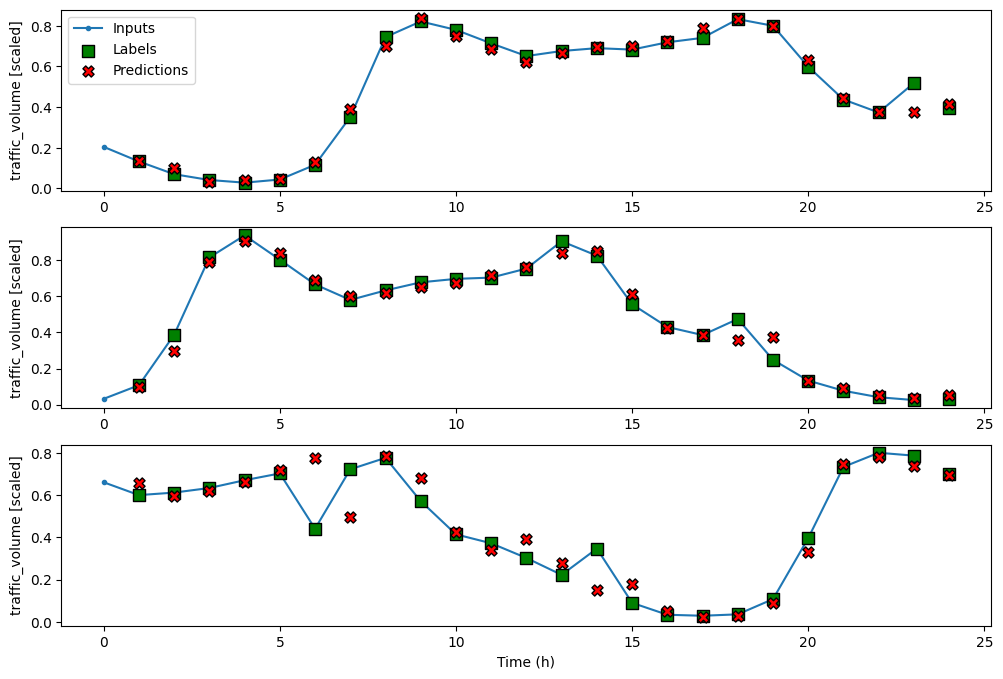

In [106]:
wide_window.plot(lstm_model)

plt.plot()

[]

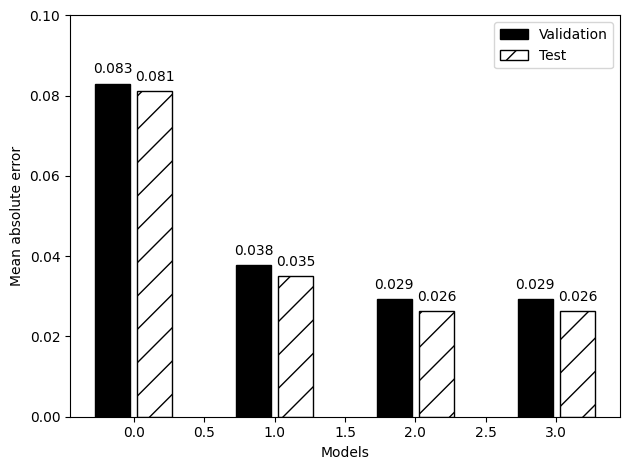

In [108]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(len(mae_val))

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.legend(loc='best')
plt.tight_layout()
plt.plot()

## Multi-Step LSTM

In [109]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [110]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 16s 31ms/step - loss: 0.0456 - mean_absolute_error: 0.1524 - val_loss: 0.0208 - val_mean_absolute_error: 0.1005
Epoch 2/50
383/383 [==============================] - 12s 30ms/step - loss: 0.0166 - mean_absolute_error: 0.0890 - val_loss: 0.0176 - val_mean_absolute_error: 0.0909
Epoch 3/50
383/383 [==============================] - 12s 31ms/step - loss: 0.0149 - mean_absolute_error: 0.0829 - val_loss: 0.0166 - val_mean_absolute_error: 0.0841
Epoch 4/50
383/383 [==============================] - 9s 23ms/step - loss: 0.0142 - mean_absolute_error: 0.0803 - val_loss: 0.0163 - val_mean_absolute_error: 0.0821
Epoch 5/50
383/383 [==============================] - 9s 25ms/step - loss: 0.0138 - mean_absolute_error: 0.0786 - val_loss: 0.0154 - val_mean_absolute_error: 0.0807
Epoch 6/50
383/383 [==============================] - 11s 28ms/step - loss: 0.0135 - mean_absolute_error: 0.0773 - val_loss: 0.0153 - val_mean_absolute_error: 0.0790
Epoch 

KeyboardInterrupt: 

## Multi-Output LSTM

In [ ]:
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [ ]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

In [ ]:
history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

In [ ]:
mo_wide_window.plot(mo_lstm_model)

plt.plot()

In [ ]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

plt.plot()

In [ ]:

mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.plot()